# Imports

In [139]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [140]:
# global imports (1 sec - 30 secs)
import random
import matplotlib.pyplot as plt
import numpy as np
import torch
from accelerate import Accelerator
from sentence_transformers import SentenceTransformer
accelerator = Accelerator()
model = accelerator.prepare(SentenceTransformer("all-mpnet-base-v2", device="cuda")) #all-MiniLM-L6-v2
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
# Get the max token size
max_token_size = model.max_seq_length
print(f"Max token size: {max_token_size}")

Max token size: 384


In [141]:
# local imports (1 sec - 2 secs)
import loader
import distances
import algos
import data_processing as dp
import classifier

In [142]:
torch.cuda.is_available()

True

In [143]:
#clear all memory of the GPU
torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.reset_peak_memory_stats(device)

# Database

The miscellaneous database consists of 20 copyright-free book from children's literature obtained from [The Project Gutenberg](https://www.gutenberg.org/ebooks/bookshelf/20).  
The Tom Swift database consists of 27 books of the series Tom Swift by Victor Appleton obtained from [The Project Gutenberg](https://www.gutenberg.org/ebooks/search/?query=victor+appleton&submit_search=Go%21).

In [144]:
#Choosing the database ("Miscellaneous", "Tom Swift") and the number of books to load (1 min)
nb_books = 25
mode = "chunks"
all_sentences = loader.load_books("Tom Swift", mode, max_token_size, tokenizer=model.tokenizer)
#Randomly reorder the books
random.shuffle(all_sentences)
sentences = all_sentences[:nb_books]

In [145]:
#choose a random book and print 1 chunk
r = random.randrange(0, len(sentences)) #not included
r2 = random.randrange(0, len(sentences[r]))
for i in range(r2, r2+1):
    print(sentences[r][i])

time. "But there may be more," he warned the young inventor. "You are not done with them yet." The Mars was floated out of her hangar, and made ready for an ascent. Tom, Ned, Lieutenant Marbury, Mr. Damon, and several workmen were to be the first passengers. Tom was busy going over the various parts to see that nothing had been forgotten. "Well, I guess we're ready," he finally announced. "All aboard!" "Bless my insurance policy!" exclaimed Mr. Damon. "Now that the time comes I almost wish I wasn't going." "Nonsense!" exclaimed Tom. "You're not going to back out at the last minute. All aboard! Cast off the ropes!" he cried to the assistants. A moment later the Mars, the biggest airship Tom Swift had ever constructed, arose from the earth like some great bird, and soared aloft. CHAPTER XV IN DANGER "Well, Tom, we're moving!" cried Ned Newton, clapping his chum on the back, as he stood near him in the pilot-house. "We're going up, old sport!" "Of course we are," replied Tom. "You didn't 

# Embeddings
Here we use Sentence-BERT to embed the sentences in the database.

In [146]:
#embeddings of the sentences (1 min - 2 min)
sentence_embedding = [model.encode(sentences[r]) for r in range(len(sentences))] #cannot stack because different number of pages

# Minimizing the distances
Here we want to find an oprtimal order by maximizing the semantic proximity between neighboring sentences. We have $n!$ possible orderings, so we can't use brute force. Our problem is similar to the traveling salesman problem, which is NP-hard, so we can't solve it optimally, therefore we design some algorithms to try to find a local minimum instead.

In [147]:
#run the local minimum algorithms on a subset of the sentences of the book and compare the permutation distances (1 sec - 4 secs)
pairwise_dist = distances.pairwise_dist(sentence_embedding)
distances2 = pairwise_dist[0][:100,:100]

default_order, random_order = list(range(len(distances2))), np.random.permutation(len(distances2))

for algo in [(lambda x, y: y), algos.insertion_sort, algos.greedy_sort]:
    for order, order_name in [(default_order, "default order"), (random_order, "random_order")]:
        for dist, dist_name in [(lambda o : distances.avg_consecutive_dist(o, distances2), "avg_consecutive_dist"), (lambda o : distances.kendall_tau(o, default_order), "kendall_tau"), (lambda o : distances.PMR(o, default_order), "PMR")]:
            ordered = algo(distances2, order)
            d = dist(ordered)
            print(f"{order_name:25}{algo.__name__:20}{dist_name:25}{d}")
        print()

default order            <lambda>            avg_consecutive_dist     0.2802770733833313
default order            <lambda>            kendall_tau              1.0
default order            <lambda>            PMR                      1.0

random_order             <lambda>            avg_consecutive_dist     0.41911566257476807
random_order             <lambda>            kendall_tau              -0.03838383838383841
random_order             <lambda>            PMR                      0.0

default order            insertion_sort      avg_consecutive_dist     0.3924892544746399
default order            insertion_sort      kendall_tau              0.41333333333333333
default order            insertion_sort      PMR                      0.07

random_order             insertion_sort      avg_consecutive_dist     0.40506401658058167
random_order             insertion_sort      kendall_tau              0.3688888888888888
random_order             insertion_sort      PMR                      0.

The insertion sort improves significantly the kendall tau compared to a random permutation.

# Classifier: 
### Heuristics
The two metrics discussed were the following: distance betweeen pages or probability that a page is before another.

For the distance between pages, we don't have the ground truth so to train a model it's easier to start with a classifier that takes in two pages and outputs a probability that the first page is before the second.

![Classifier Architecture](../img/Classifier_architecture.png)

### Training and Testing Datasets

In [148]:
#split the sentences into discard, training, validation and testing sets keeping the order
print(sentence_embedding[0].shape)
sentences_train, sentences_val, sentences_test = dp.split_sentences(sentence_embedding, 1)
print(sentences_train[0].shape, sentences_val[0].shape, sentences_test[0].shape)

(152, 768)
torch.Size([121, 768]) torch.Size([16, 768]) torch.Size([15, 768])


In [149]:
#create the database of the pairs of a subset of sentences (30 sec - 1 min for 30 books and 100%)
X_train, y_train = dp.create_database(sentences_train)
X_val, y_val = dp.create_database(sentences_val)
X_test, y_test = dp.create_database(sentences_test)
print(X_train.shape, X_val.shape, X_test.shape)     #size n x (n-1)

torch.Size([367130, 1536]) torch.Size([6123, 1536]) torch.Size([5724, 1536])


### PyTorch Classifier

#### Hyperparameters and validation

In [150]:
#hyperparameters
input_dim = X_train[0].shape[0]
output_dim = 1
hidden_dim = 128
learning_rate_list = [0.1, 0.01, 0.001, 0.0001]
epochs_list = [10, 100, 1000]
L2_alphas = [0, 0.01, 0.001, 0.0001]

In [151]:
#Create the classifier
network = classifier.Classifier(input_dim, hidden_dim, output_dim, accelerator)

The best values for the hyperparameters were found to be:
- Number of epochs: 10 000
- Learning Rate: 0.001
- L2 Regularization: 0

#### Training

In [152]:
#set the best hyperparameters
learning_rate = 0.001
epochs = 1000
L2_alpha = 0

In [153]:
#Create the classifier
network = classifier.Classifier(input_dim, hidden_dim, output_dim, accelerator)

In [154]:
#train the network with the best hyperparameters (1 mins - 1.5 min)
loss = network.train(X_train, y_train, X_val, y_val, epochs, learning_rate, L2_alpha, True)

Epoch 0: train loss 0.693332
Epoch 100: train loss 0.495657
Epoch 200: train loss 0.455550
Epoch 300: train loss 0.430837
Epoch 400: train loss 0.398537
Epoch 500: train loss 0.361953
Epoch 600: train loss 0.326608
Epoch 700: train loss 0.294181
Epoch 800: train loss 0.265242
Epoch 900: train loss 0.240079
Validation loss 0.497778


### Exploiting the classifier

#### Test of the pairwise order predictions on the test set

In [155]:
#test on the GPU
y_pred = network(X_test.float().cuda())
#BCE loss
loss = network.loss_fn()(y_pred, y_test.float().cuda())
#remove elements are diagonal elements
indices = [i for i,v in enumerate(y_test) if v==0.5]
y_pred_hole = torch.tensor([value for index, value in enumerate(y_pred) if not index in indices])
y_test_hole = torch.tensor([value for index, value in enumerate(y_test) if not index in indices])
#convert to numpy arrays and round predictions
y_test_array, y_pred_array = y_test_hole.cpu().detach().numpy(), y_pred_hole.cpu().detach().numpy().round()
#accuracy
accuracy = accuracy_score(y_test_array, y_pred_array)
#F1 score
F1 = f1_score(y_test_array, y_pred_array)
#AUC score
AUC = roc_auc_score(y_test_array, y_pred_array)

print("Number of values %d" % y_test_array.shape[0])
print("Test BCE loss %f" % loss.item())
print("Test accuracy %f" % accuracy)
print("Test F1 %f" % F1.item())
print("Test AUC %f" % AUC.item())

Number of values 5346
Test BCE loss 0.511618
Test accuracy 0.778339
Test F1 0.774071
Test AUC 0.778339


#### Test of the pairwise ordering predictions for a new book

In [156]:
#embed a new book (2.5 sec)
new_embedding = [model.encode(all_sentences[nb_books])]

In [157]:
#predict the pairwise page order in the new book using the network (2 secs)
reduced_embedding = dp.split_sentences(new_embedding, 1, 1)[0]
X2, y2 = dp.create_database(reduced_embedding)
y2_pred = network(X2.float().cuda())

In [158]:
#BCE loss
loss = network.loss_fn()(y2_pred, y2.float().cuda())
#remove elements are diagonal elements
indices = [i for i,v in enumerate(y2) if v==0.5]
y2_pred_hole = torch.tensor([value for index, value in enumerate(y2_pred) if not index in indices])
y2_hole = torch.tensor([value for index, value in enumerate(y2) if not index in indices])
#convert to numpy arrays and round predictions
y2_array, y2_pred_array = y2_hole.cpu().detach().numpy(), y2_pred_hole.cpu().detach().numpy().round()
#accuracy
accuracy = accuracy_score(y2_array, y2_pred_array)
#F1 score
F1 = f1_score(y2_array, y2_pred_array)
#AUC score
AUC = roc_auc_score(y2_array, y2_pred_array)

print("Number of values %d" % y2_array.shape[0])
print("Test BCE loss %f" % loss.item())
print("Test accuracy %f" % accuracy)
print("Test F1 %f" % F1.item())
print("Test AUC %f" % AUC.item())

Number of values 23562
Test BCE loss 0.609089
Test accuracy 0.732238
Test F1 0.715798
Test AUC 0.732238


#### Test of the transitive predictions for the new book

In [159]:
#convert the predictions to a pairwise probability matrix
pairwise_probabilities = dp.flattened_to_matrix(y2_pred)
#convert to a shifted antisymmetric matrix by averaging the predictions of the upper and lower triangular
averaged_probabilities = dp.average_matrix(pairwise_probabilities)
#test if the shifted matrix is asymmetric
print(np.sum(averaged_probabilities-0.5 + np.transpose(averaged_probabilities-0.5))==0)

True


In [160]:
#compute the min weight transitivity closure of the pairwise order graph using Floyd-Warshall
min_closure = algos.order_from_pairwise(pairwise_probabilities)

In [161]:
#convert directed edges to a list 0 and 1
transitive_pred = dp.edges_to_pred(min_closure)
#accuracy
accuracy = accuracy_score(y2_array, transitive_pred)
#F1 score
F1 = f1_score(y2_array, transitive_pred)
#AUC score
AUC = roc_auc_score(y2_array, transitive_pred)

print("Number of values %d" % transitive_pred.shape[0])
print("Test accuracy %f" % accuracy)
print("Test F1 %f" % F1.item())
print("Test AUC %f" % AUC.item())

Number of values 23562
Test accuracy 0.687251
Test F1 0.680318
Test AUC 0.687251


In [162]:
#compute obtimal order the topological sort algorithm
pred_order = algos.topological_sort(min_closure)

In [163]:
#compare with the actual order of pages
ground_truth_order = list(range(len(new_embedding[0])))
print("Kendall tau: %f" % distances.kendall_tau(pred_order, ground_truth_order))
print("Perfect Match Ratio: %f" % distances.PMR(pred_order, ground_truth_order))

Kendall tau: 0.378321
Perfect Match Ratio: 0.025974


#### Test of the transitive closure method on synthetic predictions

In [164]:
def order_from_synthetic(x_precision, y_precision, y2):
    tau = []
    PMR = []
    #error proability
    errors = [x_precision*i for i in range(int(1/x_precision))]
    for error in errors:
        Ltau = []
        LPMR = []
        for i in range(int(1/y_precision)):
            #create random noise with probability error
            noise = np.random.choice([0, 1], size=y2.shape, p=[1-error, error])
            #add this noise to the ground truth to make a synthetic prediction
            synthetic_pred = np.where(noise==0, y2, 1-y2)
            #compute order from the synthetic prediction using the transitive closure method
            pairwise_probabilities = dp.flattened_to_matrix(torch.tensor(synthetic_pred))
            min_closure = algos.order_from_pairwise(pairwise_probabilities)
            pred_order = algos.topological_sort(min_closure)
            Ltau.append(distances.kendall_tau(pred_order, ground_truth_order))
            LPMR.append(distances.PMR(pred_order, ground_truth_order))
        tau.append(np.mean(Ltau))
        PMR.append(np.mean(LPMR))
    return(errors, tau, PMR)

c:\Users\victo\Documents\Scolaire\EPFL 2022-2024\Semester 3\Jawbone\src\algos.py:135: RuntimeWarning: divide by zero encountered in scalar divide
  val = abs(np.log(pairwise_probs[i][j]/(1-pairwise_probs[i][j])))
c:\Users\victo\Documents\Scolaire\EPFL 2022-2024\Semester 3\Jawbone\src\algos.py:135: RuntimeWarning: divide by zero encountered in log
  val = abs(np.log(pairwise_probs[i][j]/(1-pairwise_probs[i][j])))


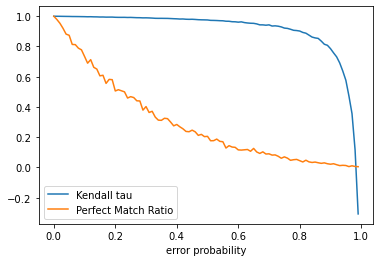

In [165]:
#plot the results with legend
errors, tau, PMR = order_from_synthetic(0.01, 0.1, y2.cpu().detach())
plt.plot(errors, tau, label="Kendall tau")
plt.plot(errors, PMR, label="Perfect Match Ratio")
plt.xlabel("error probability")
plt.legend()

# Set Transformer:
### Heuristics 
Full transformer network that takes in pages and outputs an order, the architecture for this set-to-sequence model comes from [Set Transformer](https://arxiv.org/abs/1810.00825).

DRAWING